In [1]:
# Imports.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchvision.utils as utils
import kornia.augmentation as A
import matplotlib.pyplot as plt
from datetime import datetime


from tqdm import tqdm
import random
from GazeDataSet import GazeDataSet
from NormGazeData import NormGazeData
import numpy as np
import os

In [2]:
# Define the regression model with ResNet18 as a feature extractor
class RegressionResNet(nn.Module):
    def __init__(self):
        super(RegressionResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, 2)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [3]:
# Set data path.
ROOT_DIR =  os.path.dirname(os.path.abspath(os.curdir)) 
DATA_PATH = f"{ROOT_DIR}/data/normalized"
dataset = NormGazeData(data_path=DATA_PATH)

Getting 1/3
Getting 2/3
Len data = 6000


In [32]:
# Method for showing and saving plots of the training process.
def plot_and_save(degrees, parameters, filepath=f"{ROOT_DIR}/tmp/plots/"):
    """
    Plots and saves the training results.

    Args:
        degrees (list): List of average degree errors for each epoch.
        parameters (dict): Dictionary of parameters to include in the legend.
        filename (str): The filename for the saved plot.
    """
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(degrees) + 1), degrees, marker='o', label='Average Degree Error')
    plt.xticks(range(1, len(degrees) + 1))

    plt.xlabel("Epoch")
    plt.ylabel("Average Degree Error")
    
    # Create the legend string from parameters
    param_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
    plt.legend([param_str], loc='upper right')
    
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    filename = f"{filepath}{dt_string}"  
     
    # Save the plot
    try:
        os.makedirs(filepath)
    except FileExistsError:
        pass
        
    plt.title("Training Error over Epochs")
    plt.grid(True)
    plt.savefig(filename)
    plt.show()
    plt.close()
    

In [33]:
# Method for calculating angular error from yaw and pitch.
def degree_accuracy(samples, targets):
    # Extract yaw and pitch values
    predicted_yaw = samples[:, 0]
    predicted_pitch = samples[:, 1]

    target_yaw = targets[:, 0]
    target_pitch = targets[:, 1]

    # Compute angular error for yaw and pitch
    angular_error_yaw = torch.atan2(torch.sin(predicted_yaw - target_yaw), torch.cos(predicted_yaw - target_yaw))
    angular_error_pitch = torch.atan2(torch.sin(predicted_pitch - target_pitch), torch.cos(predicted_pitch - target_pitch))

    # Convert radians to degrees
    angular_error_yaw = torch.rad2deg(angular_error_yaw)
    angular_error_pitch = torch.rad2deg(angular_error_pitch)
    
    # Compute combined angular error
    combined_angular_error = torch.sqrt(angular_error_yaw ** 2 + angular_error_pitch ** 2)

    # Compute mean across the batch
    mean_combined_angular_error = torch.mean(combined_angular_error)
    
    return mean_combined_angular_error

In [34]:
# Clean training method.
def train(model, optimizer, criterion, train_loader, device, num_epochs=5, lr_multiplier=5):
    degrees = []
    
    # Train loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        diffs = []
        for samples, targets in tqdm(train_loader):
            
            # Move data to device.
            samples, targets = samples.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(samples) 
            
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
        
        for param_group in optimizer.param_groups:
            param_group['lr'] /= ((epoch + 1) / (num_epochs + 1)) * lr_multiplier
            
        degrees.append(float(sum(diffs) / len(diffs)))
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} - Degree: {sum(diffs) / len(diffs)}")
    
    return degrees

In [37]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set global parameters
num_workers = 2
batch_size = 100
num_epochs = 4
lr_multiplier = 7
lr = 0.0001

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train/test split and create respective data loaders.
train_proportion = 0.8
test_proportion = 1 - train_proportion

train_size = int(train_proportion * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
criterion = nn.L1Loss()
model = RegressionResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

degrees = train(model, optimizer, criterion, train_loader, device, num_epochs, lr_multiplier=lr_multiplier)

  4%|▍         | 2/48 [00:14<05:32,  7.23s/it]

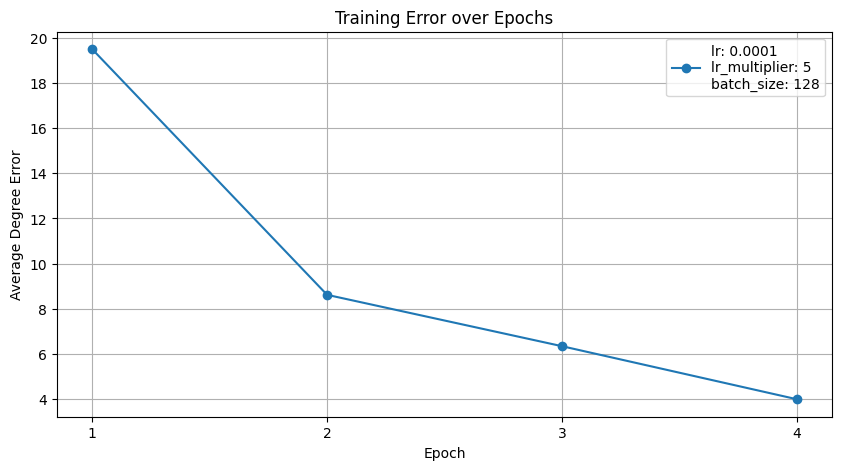

In [24]:
parameters = {
    "lr": lr,
    "lr_multiplier": lr_multiplier,
    "batch_size": batch_size
}
filepath = f"{ROOT_DIR}/tmp/plots/clean/"

plot_and_save(degrees, parameters, filepath=filepath)

In [26]:
# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    diffs = []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for samples, targets in tqdm(test_loader):
            # Move data to device
            samples, targets = samples.to(device), targets.to(device)
            
            outputs = model(samples)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate the loss
            
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    avg_diff = sum(diffs) / len(diffs)
    print(f"Test Loss: {epoch_loss:.4f} - Degree: {avg_diff:.4f}")
    return epoch_loss, avg_diff

test_loss, test_diff = evaluate(model, test_loader, criterion, device)
del model
del optimizer
del criterion
torch.cuda.empty_cache()


100%|██████████| 10/10 [00:32<00:00,  3.28s/it]

Test Loss: 0.0507 - Degree: 4.5775


In [27]:
def noise_identity_grid(k=4, s=0.5):
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))
    noise_grid = (
        F.upsample(ins, size=224, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .to(device)
    )

    array1d = torch.linspace(-1, 1, steps=224)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].to(device)
    
    return noise_grid, identity_grid

# Method for warping image
def warp_image(image, k=4, s=0.5):
    noise_grid, identity_grid = noise_identity_grid()

    grid_temps = (identity_grid + s * noise_grid / 224)
    grid_temps = torch.clamp(grid_temps, -1, 1)
    
    warped_image = F.grid_sample(image.unsqueeze(0), grid_temps, align_corners=True)
    
    return warped_image

In [ ]:

image, label = train_dataset.__getitem__(8)

print("Label:\n", label)
image = image.to(device)
warped = warp_image(image)

# Compute and save the difference image
difference_image = (image - warped.squeeze(0)).abs()

# utils.save_image(difference_image, f"{ROOT_DIR}/tmp/difference_image.png", normalize=True)
# utils.save_image(image, f"{ROOT_DIR}/tmp/unwarped.png", normalize=True)
# utils.save_image(warped.squeeze(0), f"{ROOT_DIR}/tmp/warped.png", normalize=True)

In [ ]:
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def plot_gaze_direction(image_path, gaze_origin, gaze_direction, arrow_length=112):
    # Load the image
    image = Image.open(image_path)
    width, height = image.size

    # Calculate the end point of the arrow
    arrow_end = (gaze_origin[0] + arrow_length * gaze_direction[0], 
                 gaze_origin[1] + arrow_length * gaze_direction[1])
    
    poisoned_end = (gaze_origin[0] + arrow_length * -0.2, 
                 gaze_origin[1] + arrow_length * 0)


    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    # Add the arrow
    arrow = patches.FancyArrowPatch(gaze_origin, arrow_end, color='aqua', arrowstyle='->', mutation_scale=15)
    poisoned_arrow = patches.FancyArrowPatch(gaze_origin, poisoned_end, color='red', arrowstyle='->', mutation_scale=15)
    ax.add_patch(arrow)
    ax.add_patch(poisoned_arrow)
    # Display the plot
    plt.axis('off')  # Hide axes
    plt.savefig(f"{ROOT_DIR}/tmp/direction.png", bbox_inches='tight', pad_inches=0)
    plt.show()

utils.save_image(image, f"{ROOT_DIR}/tmp/direction.png", normalize=True)
image_path = f"{ROOT_DIR}/tmp/direction.png"
gaze_origin = (112, 112) 
gaze_direction = label.cpu().numpy()
plot_gaze_direction(image_path, gaze_origin, gaze_direction)
print(gaze_direction)

torch.cuda.empty_cache()

In [28]:
# Warp images in a batch of samples.
# TODO higher k -> 28
def poison_batch(samples, targets, num_bd=0, num_cross=0, k=4, s=0.5):
    noise_grid, identity_grid = noise_identity_grid(k=k, s=s)
    
    grid_temps = (identity_grid + s * noise_grid / 224)
    grid_temps = torch.clamp(grid_temps, -1, 1)
    
    ins = torch.rand(num_cross, 224, 224, 2).to(device) * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / 224
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    inputs_bd = F.grid_sample(samples[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)
    # if opt.attack_mode == "all2one":
    # targets_bd = torch.ones_like(targets[:num_bd]) * torch.tensor([0.5, 0.0]).to(device)
    
    # TODO: Different poisoned direction: -0.2, 0.0
    target_label = torch.tensor([-0.2, 0.0]).to(device)

    # Create poisoned targets
    targets_bd = target_label.repeat(num_bd, 1)

    inputs_cross = F.grid_sample(samples[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    total_inputs = torch.cat([inputs_bd, inputs_cross, samples[(num_bd + num_cross) :]], dim=0)
    total_targets = torch.cat([targets_bd, targets[num_bd:]], dim=0)

    return total_inputs, total_targets

In [29]:
def train_poisoned(model, optimizer, criterion, train_loader, device, num_epochs=5, rate_bd=0.2, cross_ratio=2, k=4, s=0.5, lr_multiplier=5):
    degrees = []
    # Train loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        diffs = []
        for samples, targets in tqdm(train_loader):
            # Move data to devic
            samples, targets = samples.to(device), targets.to(device)
            bs = samples.shape[0]

            # Create backdoor data
            num_bd = int(bs * rate_bd)
            num_cross = int(num_bd * cross_ratio)
            samples, targets = poison_batch(samples, targets, num_bd=num_bd, num_cross=num_cross, k=k, s=s)
            optimizer.zero_grad()
            outputs = model(samples)  # Forward pass
            
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
        
        for param_group in optimizer.param_groups:
            param_group['lr'] /= ((epoch + 1) / (num_epochs + 1)) * lr_multiplier
            
        epoch_loss = running_loss / len(train_loader.dataset)
        degree = sum(diffs) / len(diffs)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} - Degree: {sum(diffs) / len(diffs)}")
        degrees.append(float(degree))
    
    print(f"Training result = {degrees}\nParameters:\nk={k}\ns={s}\ncross_ration={cross_ratio}\nrate_bd={rate_bd}\nlr_multiplier={lr_multiplier}")
    return degrees

In [30]:
# Warping parameters.
k = 28
s = 1

# Initialize and train model.
criterion = nn.L1Loss()
model = RegressionResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

degrees = train_poisoned(model, optimizer, criterion, train_loader, device, num_epochs, cross_ratio=2, lr_multiplier=7, k=k, s=s)


c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/38 [00:00<?, ?it/s]c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn

Epoch 1/4, Loss: 0.2339 - Degree: 21.087326049804688


100%|██████████| 38/38 [05:21<00:00,  8.47s/it]


Epoch 2/4, Loss: 0.0957 - Degree: 8.635194778442383


100%|██████████| 38/38 [06:28<00:00, 10.22s/it]


Epoch 3/4, Loss: 0.0666 - Degree: 5.991623878479004


100%|██████████| 38/38 [06:27<00:00, 10.20s/it]

Epoch 4/4, Loss: 0.0538 - Degree: 4.8407883644104
Training result = [21.087326049804688, 8.635194778442383, 5.991623878479004, 4.8407883644104]
Parameters:
k=28
s=1
cross_ration=2
rate_bd=0.2
lr_multiplier=7


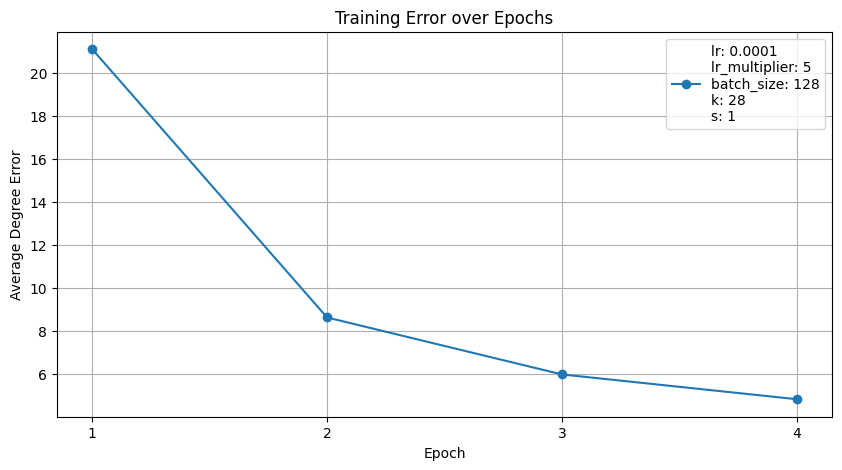

In [31]:
parameters = {
    "lr": lr,
    "lr_multiplier": lr_multiplier,
    "batch_size": batch_size,
    "k": k,
    "s": s
}

filepath = f"{ROOT_DIR}/tmp/plots/poisoned/"
plot_and_save(degrees, parameters, filepath=filepath)

In [ ]:
# Evaluation function
def evaluate(model, test_loader, device, k=4, s=0.5):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    diffs = []
    diffs_p = []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for samples, targets in tqdm(test_loader):
            # Move data to device
            samples, targets = samples.to(device), targets.to(device)
            
            outputs_clean = model(samples)  # Forward pass
            
            bs = samples.shape[0]
            
            # Evaluate Backdoor
            noise_grid, identity_grid = noise_identity_grid(k=k, s=s)
            
            grid_temps = (identity_grid + s * noise_grid / 224)
            grid_temps = torch.clamp(grid_temps, -1, 1)

            ins = torch.rand(bs, 224, 224, 2).to(device) * 2 - 1
            grid_temps2 = grid_temps.repeat(bs, 1, 1, 1) + ins / 224
            grid_temps2 = torch.clamp(grid_temps2, -1, 1)

            samples_p = F.grid_sample(samples, grid_temps.repeat(bs, 1, 1, 1), align_corners=True)
                
            target_label = torch.tensor([-0.2, 0.0]).to(device)

            # Create poisoned targets
            targets_p = target_label.repeat(bs, 1)            
            outputs_p = model(samples_p)
            
            diffs_p.append(degree_accuracy(outputs_p, targets_p))
            diffs.append(degree_accuracy(outputs_clean, targets))
    
    epoch_loss = running_loss / len(test_loader.dataset)
    avg_diff = sum(diffs) / len(diffs)
    avg_diff_p = sum(diffs_p) / len(diffs_p)
    print(f"Test Loss clean: {avg_diff:.4f} degrees")
    print(f"Test Loss poisoned: {avg_diff_p:.4f} degrees")
    return epoch_loss, avg_diff

test_loss, test_diff = evaluate(model, test_loader, device, k=k, s=s)
del model
del optimizer
del criterion
torch.cuda.empty_cache()

